In [72]:
import warnings
warnings.filterwarnings("ignore")

In [73]:
import sys
import os

sys.path.append(os.path.abspath('../src'))

In [74]:
import PreProccesing as PP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib


In [75]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier



from sklearn.metrics import precision_score, recall_score, fbeta_score, accuracy_score
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [82]:
df = PP.load_data('..\data\WA_Fn-UseC_-Telco-Customer-Churn.csv')
X, y = PP.split_X_y(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_orginal, X_test_orginal, y_train_orginal, y_test_orginal = PP.encode_cat_num(X_train, X_test, y_train, y_test)
model_columns = X_train_orginal.columns
joblib.dump(model_columns, "../app/model_columns.pkl") 
scaler = MinMaxScaler()
X_train_orginal = scaler.fit_transform(X_train_orginal)
joblib.dump(scaler, "../app/orginal_scaler.pkl")
X_test_orginal = scaler.transform(X_test_orginal)

In [81]:
df = PP.load_data('..\data\WA_Fn-UseC_-Telco-Customer-Churn.csv')
X, y = PP.split_X_y(df)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train_resampled, y_train_resampled = PP.undersampling_data(X_train, y_train)
X_train_resampled, y_train_resampled = PP.oversampling_data(X_train_resampled, y_train_resampled)
X_train_resampled , X_test_resampled, y_train_resampled, y_test_resampled = PP.encode_cat_num(X_train_resampled, X_test, y_train_resampled, y_test)
model_columns = X_train_resampled.columns
joblib.dump(model_columns, "../app/model_columns.pkl") 
scaler = MinMaxScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
joblib.dump(scaler, "../app/resampled_scaler.pkl")
X_test_resampled = scaler.transform(X_test_resampled)

In [7]:
columns = ['Model', 'Recall_Churn', 'F2_Score_Churn', 'Accuracy']
results_df = pd.DataFrame(columns=columns)

def result_of_model(model_name, model, X_test, y_test):
    global results_df
    y_pred = model.predict(X_test)
    f2 = fbeta_score(y_test, y_pred, beta=2, pos_label=1)
    print(classification_report(y_test, y_pred))
    print(f"f2: {f2}")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Churn', 'Churn'], yticklabels=['Non-Churn', 'Churn'], cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    report = classification_report(y_test, y_pred, output_dict=True)
    new_row = pd.DataFrame({
        'Model': [model_name],
        'Recall_Churn': [report['1']['recall']],
        'F2_Score_Churn': f2,
        'Accuracy': [report['accuracy']]
    })
    
    results_df = pd.concat([results_df, new_row], ignore_index=True)

## Models for orginal datas

### KNN

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'metric': 'minkowski', 'n_neighbors': np.int64(49), 'p': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1031
           1       0.60      0.57      0.58       371

    accuracy                           0.79      1402
   macro avg       0.72      0.72      0.72      1402
weighted avg       0.78      0.79      0.78      1402

f2: 0.5728314238952537


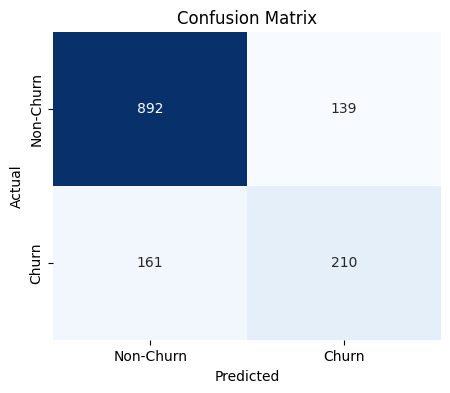

In [8]:
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': np.arange(50), 
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2],
    }
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_orginal, y_train_orginal)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('KNN-orginal' ,best_model, X_test_orginal, y_test_orginal)

### RandomForest

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'class_weight': 'balanced', 'max_features': 'log2', 'n_estimators': 700}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1031
           1       0.62      0.44      0.52       371

    accuracy                           0.78      1402
   macro avg       0.72      0.67      0.69      1402
weighted avg       0.77      0.78      0.77      1402

f2: 0.4711593375214163


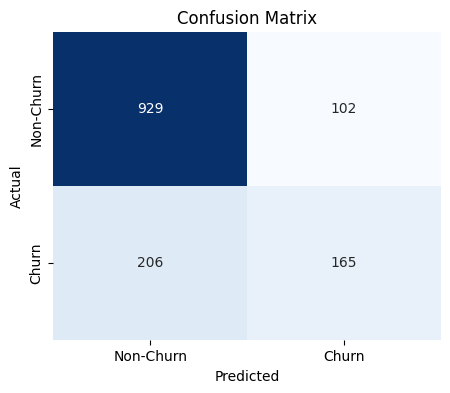

In [9]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700],
    'class_weight': ['balanced'],
    'max_features': ['auto', 'sqrt', 'log2']
    }
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_orginal, y_train_orginal)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('RandomForest-orginal' ,best_model, X_test_orginal, y_test_orginal)

### LogisticRegression

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1031
           1       0.51      0.78      0.62       371

    accuracy                           0.74      1402
   macro avg       0.71      0.75      0.71      1402
weighted avg       0.80      0.74      0.76      1402

f2: 0.7027818448023426


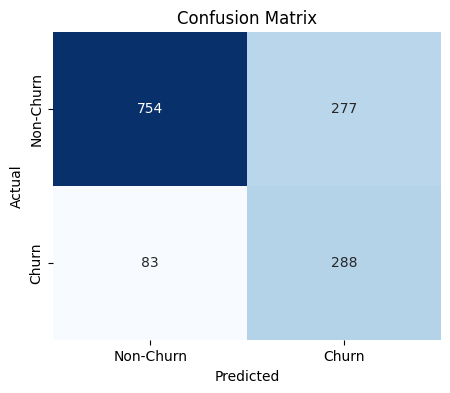

In [10]:
model = LogisticRegression()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'saga'],
    'penalty': ['l2', 'none'] 
}
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_orginal, y_train_orginal)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('LogisticReggression-orginal' ,best_model, X_test_orginal, y_test_orginal)

### XGBoost

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'learning_rate': 0.01, 'n_estimators': 200, 'scale_pos_weight': 6}
              precision    recall  f1-score   support

           0       0.93      0.59      0.72      1031
           1       0.44      0.88      0.58       371

    accuracy                           0.67      1402
   macro avg       0.69      0.74      0.65      1402
weighted avg       0.80      0.67      0.69      1402

f2: 0.7337807606263982


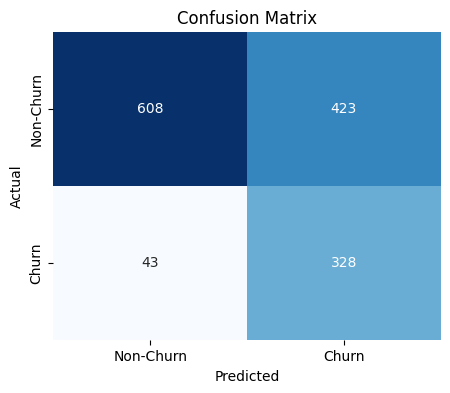

In [11]:
model = xgb.XGBClassifier(objective='binary:logistic', tree_method= 'gpu_hist')
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'scale_pos_weight': [1, 3, 6]
    }
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_orginal, y_train_orginal)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('XGBoost-orginal' ,best_model, X_test_orginal, y_test_orginal)

### SVC

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       0.91      0.67      0.77      1031
           1       0.47      0.82      0.60       371

    accuracy                           0.71      1402
   macro avg       0.69      0.75      0.69      1402
weighted avg       0.80      0.71      0.73      1402

f2: 0.7169634489222118


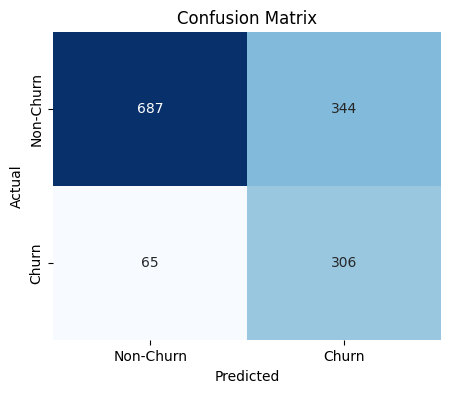

In [12]:
model = SVC()
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'class_weight': ['balanced', None],
    }
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_orginal, y_train_orginal)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('SCV-orginal' ,best_model, X_test_orginal, y_test_orginal)

### AdaBoost

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'learning_rate': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.93      0.58      0.71      1031
           1       0.43      0.88      0.58       371

    accuracy                           0.66      1402
   macro avg       0.68      0.73      0.65      1402
weighted avg       0.80      0.66      0.68      1402

f2: 0.730186999109528


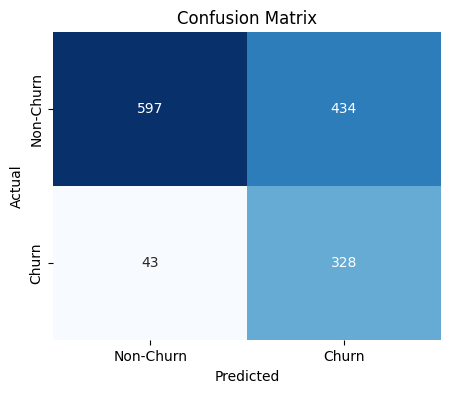

In [13]:
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1, 2],
}
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_orginal, y_train_orginal)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('Ada_boost-orginal' ,best_model, X_test_orginal, y_test_orginal)

### RidgeClassifier

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'alpha': 1.0, 'class_weight': 'balanced', 'solver': 'auto'}
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1031
           1       0.51      0.77      0.61       371

    accuracy                           0.74      1402
   macro avg       0.70      0.75      0.71      1402
weighted avg       0.80      0.74      0.76      1402

f2: 0.6992665036674817


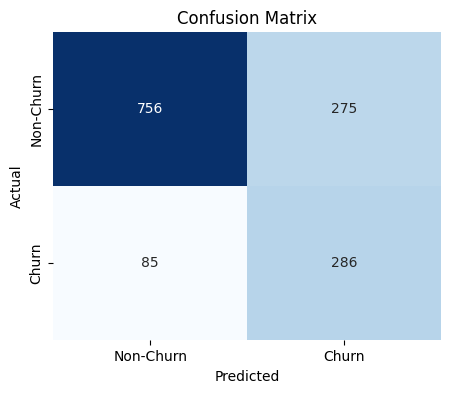

In [14]:
model = RidgeClassifier()

param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'class_weight': ['balanced'],
    'solver': ['auto', 'sag', 'lsqr']
}
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_orginal, y_train_orginal)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('Ridge-orginal' ,best_model, X_test_orginal, y_test_orginal)

### models for resampled dataset

### KNN

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best parameters: {'metric': 'minkowski', 'n_neighbors': np.int64(47), 'p': 1, 'weights': 'uniform'}
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1031
           1       0.48      0.81      0.60       371

    accuracy                           0.71      1402
   macro avg       0.69      0.75      0.69      1402
weighted avg       0.79      0.71      0.73      1402

f2: 0.7112476370510397


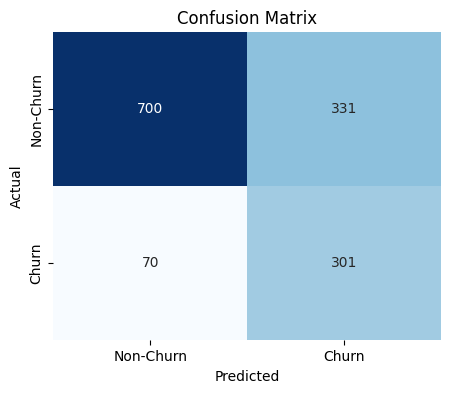

In [15]:
model = KNeighborsClassifier()
param_grid = {
    'n_neighbors': np.arange(50), 
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski'],
    'p': [1, 2],
    }
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('KNN-resampled' ,best_model, X_test_resampled, y_test_resampled)

### RandomForest

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best parameters: {'max_features': 'sqrt', 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1031
           1       0.55      0.64      0.59       371

    accuracy                           0.77      1402
   macro avg       0.71      0.73      0.71      1402
weighted avg       0.78      0.77      0.77      1402

f2: 0.6207616066770997


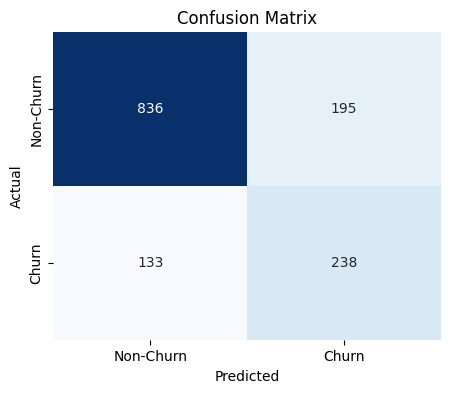

In [16]:
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 500, 700, 1000],
    'max_features': ['auto', 'sqrt', 'log2']
    }
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('RandomForest-resampled' ,best_model, X_test_resampled, y_test_resampled)

### LogisticRegression

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'C': 100, 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      1031
           1       0.53      0.76      0.62       371

    accuracy                           0.75      1402
   macro avg       0.71      0.76      0.72      1402
weighted avg       0.80      0.75      0.77      1402

f2: 0.6958890539871223


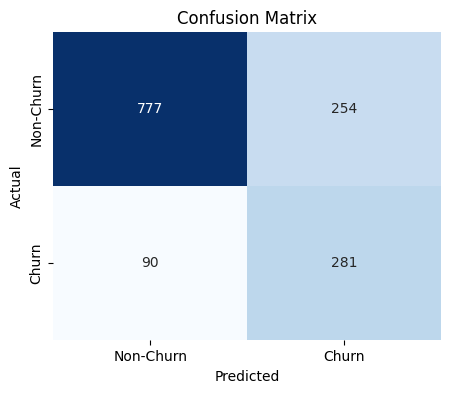

In [17]:
model = LogisticRegression()
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga']
}
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('LogisticReggression-resampled' ,best_model, X_test_resampled, y_test_resampled)

### XGBoost

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      1031
           1       0.54      0.69      0.61       371

    accuracy                           0.76      1402
   macro avg       0.71      0.74      0.72      1402
weighted avg       0.79      0.76      0.77      1402

f2: 0.65284178187404


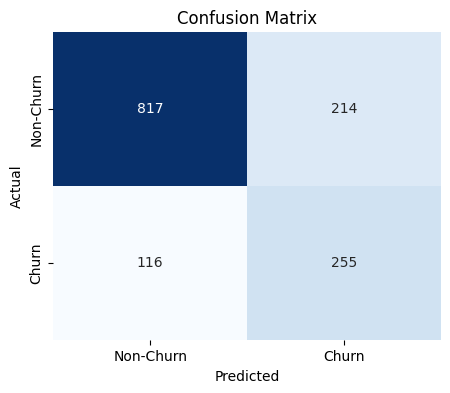

In [18]:
model = xgb.XGBClassifier(objective='binary:logistic', tree_method= 'gpu_hist')
param_grid = {
    'n_estimators': [50, 100, 200, 500],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    }
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('XGBoost-resampled' ,best_model, X_test_resampled, y_test_resampled)

### SVC

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       0.88      0.76      0.81      1031
           1       0.51      0.71      0.60       371

    accuracy                           0.74      1402
   macro avg       0.70      0.73      0.70      1402
weighted avg       0.78      0.74      0.76      1402

f2: 0.658487731597396


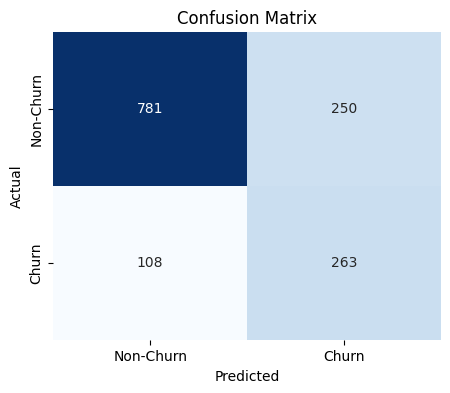

In [19]:
model = SVC()
param_grid = {
    'C': [0.1, 0.5, 1, 5, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'class_weight': ['balanced', None],
    }
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('SCV-resampled' ,best_model, X_test_resampled, y_test_resampled)

### AdaBoost

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'learning_rate': 0.01, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.93      0.64      0.76      1031
           1       0.46      0.86      0.60       371

    accuracy                           0.70      1402
   macro avg       0.69      0.75      0.68      1402
weighted avg       0.80      0.70      0.72      1402

f2: 0.7333333333333333


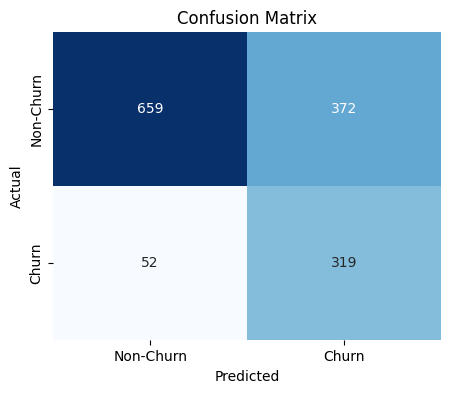

In [20]:
model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1, 2],
}
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1)
stratified_kfold = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=stratified_kfold, scoring=f2_scorer, n_jobs=4, verbose=1)
grid_search.fit(X_train_resampled, y_train_resampled)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
result_of_model('Ada_boost-resampled' ,best_model, X_test_resampled, y_test_resampled)

## Compare

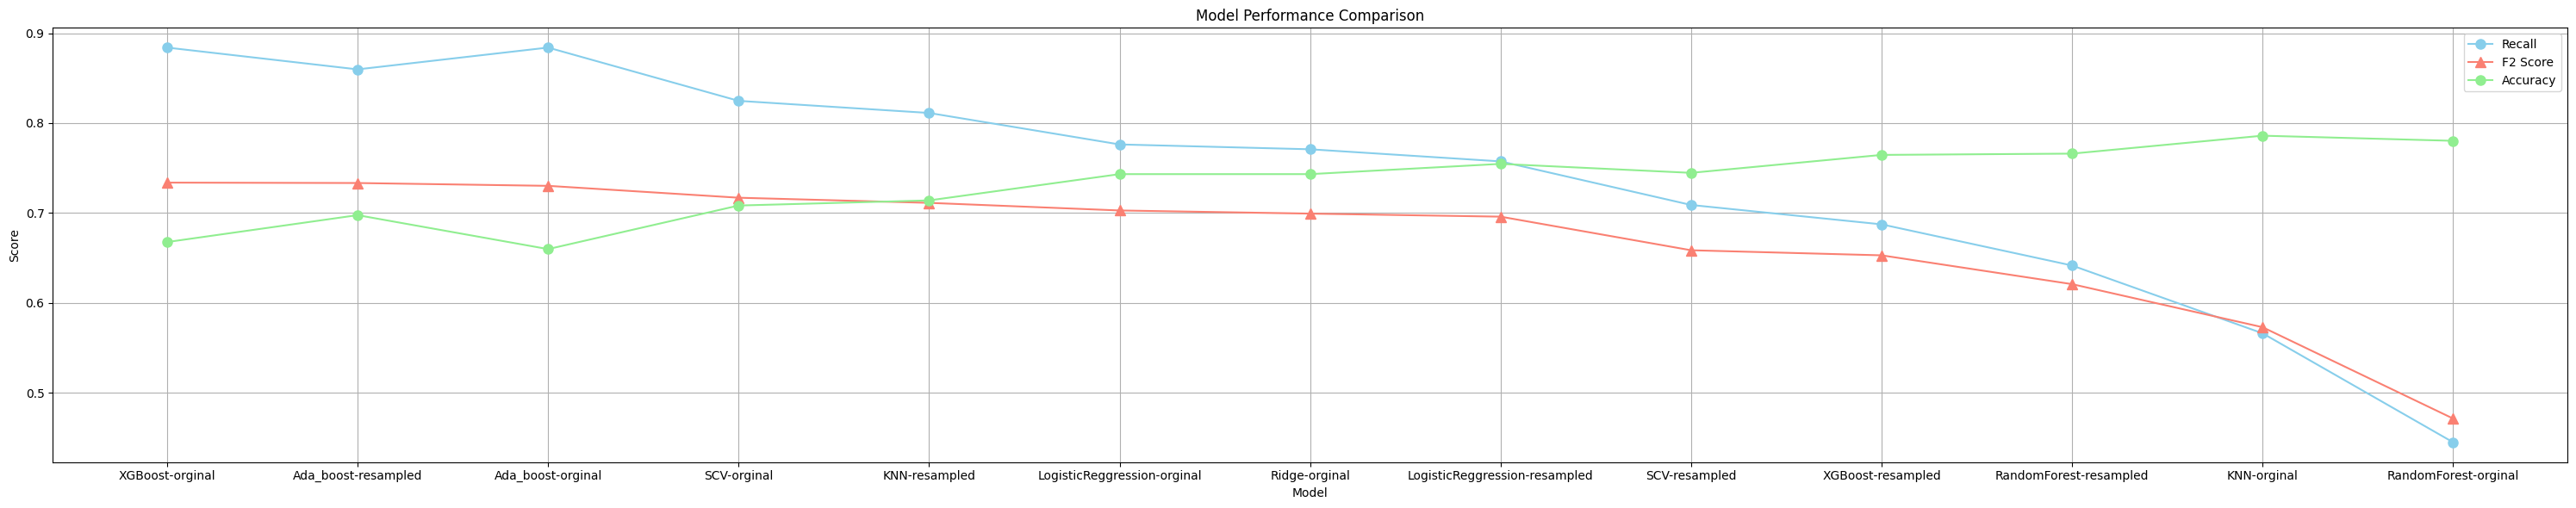

In [21]:
plt.figure(figsize=(30, 6))

results_df = results_df.sort_values(by='F2_Score_Churn', ascending=False)
plt.plot(results_df['Model'], results_df['Recall_Churn'], marker='o', label='Recall', color='skyblue', linestyle='-', markersize=8)
plt.plot(results_df['Model'], results_df['F2_Score_Churn'], marker='^', label='F2 Score', color='salmon', linestyle='-', markersize=8)
plt.plot(results_df['Model'], results_df['Accuracy'], marker='o', label='Accuracy', color='lightgreen', linestyle='-', markersize=8)

plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### improve best model

In [27]:
model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=6, learning_rate=0.01, n_estimators=200)
model.fit(X_train_orginal, y_train_orginal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [46]:
y_probs = model.predict_proba(X_test_orginal)[:, 1]
thresholds = np.arange(0.1, 0.91, 0.05)
results = []

for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test_orginal, y_pred)
    recall = recall_score(y_test_orginal, y_pred)
    f2 = fbeta_score(y_test_orginal, y_pred, beta=2)
    acc = accuracy_score(y_test_orginal, y_pred)
    results.append([thresh, precision, recall, f2, acc])

results_df = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F2_Score', 'Accuracy'])
results_df

,Threshold,Precision,Recall,F2_Score,Accuracy
0,0.10,0.265379,1.000000,0.643650,0.267475
1,0.15,0.318064,0.991914,0.696706,0.435093
2,0.20,0.338889,0.986523,0.713729,0.487161
3,0.25,0.357493,0.983827,0.728543,0.527817
4,0.30,0.368098,0.970350,0.731113,0.551355
5,0.35,0.381818,0.962264,0.737908,0.577746
6,0.40,0.397059,0.946092,0.741132,0.605563
7,0.45,0.407363,0.924528,0.737317,0.624108
8,0.50,0.436751,0.884097,0.733781,0.667618
9,0.55,0.459302,0.851752,0.727440,0.695435


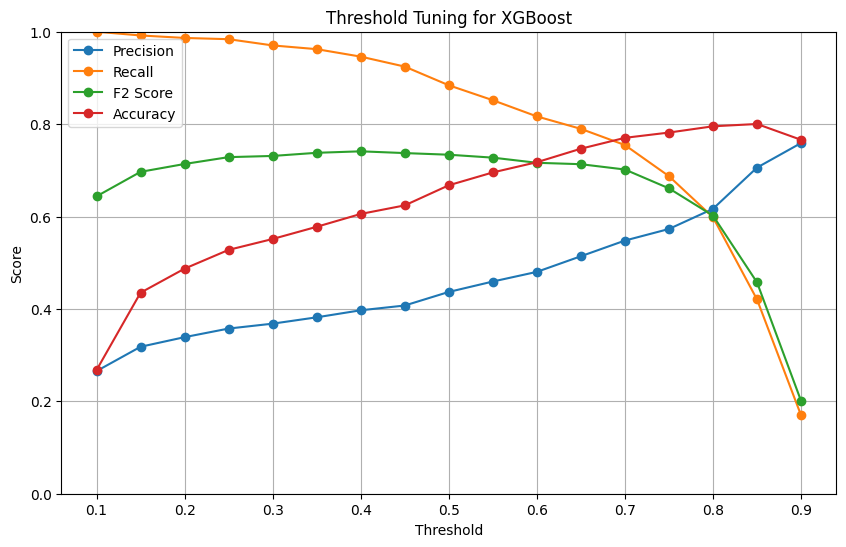

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(results_df['Threshold'], results_df['Precision'], label='Precision', marker='o')
plt.plot(results_df['Threshold'], results_df['Recall'], label='Recall', marker='o')
plt.plot(results_df['Threshold'], results_df['F2_Score'], label='F2 Score', marker='o')
plt.plot(results_df['Threshold'], results_df['Accuracy'], label='Accuracy', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning for XGBoost')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [49]:
y_probs = model.predict_proba(X_test_orginal)[:, 1]
thresholds = np.arange(0.55, 0.66, 0.01)
results = []

for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test_orginal, y_pred)
    recall = recall_score(y_test_orginal, y_pred)
    f2 = fbeta_score(y_test_orginal, y_pred, beta=2)
    acc = accuracy_score(y_test_orginal, y_pred)
    results.append([thresh, precision, recall, f2, acc])

results_df = pd.DataFrame(results, columns=['Threshold', 'Precision', 'Recall', 'F2_Score', 'Accuracy'])
results_df

,Threshold,Precision,Recall,F2_Score,Accuracy
0,0.55,0.459302,0.851752,0.727440,0.695435
1,0.56,0.462334,0.843666,0.724202,0.699001
2,0.57,0.469789,0.838275,0.724604,0.706847
3,0.58,0.474576,0.830189,0.721988,0.711840
4,0.59,0.477449,0.827493,0.721674,0.714693
5,0.60,0.480190,0.816712,0.716312,0.717546
6,0.61,0.487805,0.808625,0.714626,0.724679
7,0.62,0.491776,0.805930,0.714627,0.728245
8,0.63,0.500846,0.797844,0.713253,0.736091
9,0.64,0.508621,0.795148,0.714632,0.742511


In [50]:
thresholds = [0.5, 0.6, 0.63]
for thresh in thresholds:
    y_pred = (y_probs >= thresh).astype(int)
    cm = confusion_matrix(y_test_orginal, y_pred)
    cm_df = pd.DataFrame(cm, 
                         index=['Actual No', 'Actual Yes'], 
                         columns=['Predicted No', 'Predicted Yes'])
    print(f"\nThreshold: {thresh}")
    print(cm_df)


Threshold: 0.5
            Predicted No  Predicted Yes
Actual No            608            423
Actual Yes            43            328

Threshold: 0.6
            Predicted No  Predicted Yes
Actual No            703            328
Actual Yes            68            303

Threshold: 0.63
            Predicted No  Predicted Yes
Actual No            736            295
Actual Yes            75            296


In [71]:
import xgboost as xgb
final_model = xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=6, learning_rate=0.01, n_estimators=200, thresholds=0.6)
final_model.fit(X_train_orginal, y_train_orginal)
joblib.dump(final_model, "../app/model.pkl")

['../app/model.pkl']